In [1]:
seed = 3906303

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import r2_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder

import pickle
import glob, os
import gzip
import random
np.random.seed(seed)
random.seed(seed)

In [3]:
print(tf.__version__)

2.10.0


## Load dataset

Here we read in all the measurement files created in the datagen notebook. Each dataframe is a separate file, which is each a separate table of measurement readings of particular types.

In [4]:
# Create dictionary of measurement-type dataframes
MEAS = {
    name: pd.read_csv(
        fp,
        parse_dates=['charttime'],       # parsed dates on the fly
        low_memory=False                 # avoids mixed-type warnings
    )
    for fp  in sorted(glob.glob('Datagen/*_filtered_chartevents.csv'))
    for name in [os.path.basename(fp).split('_')[0]]
}

FEATURES = list(MEAS.keys())
F        = len(FEATURES)             # number of features
GLU_IDX  = FEATURES.index('bg')     # which column contains glucose

In [5]:
FEATURES

['abpm', 'bg', 'cvp', 'f', 'hr', 'hrh', 'hrl', 'nbpm', 'rr', 'spo2']

# Data filtering and cleaning

Below we filter impossible values for the physiological features. No negative numbers, except for rare cases of CVP feature.

In [5]:
#  Per-variable rules. Only reject impossible numbers
LOGIC_RULES = {
    'bg' : lambda s: (s >= 10) & (s <= 2656),                     # historically recorded extreme mg/dL
    'hr'  : lambda s: (s >= 20) & (s <= 600),                     # beats / min
    'rr'  : lambda s: (s >= 6) & (s <= 60),                       # breaths / min
    'spo2': lambda s: (s >= 50) & (s <= 100),                     # % saturation
    'nbpm': lambda s: (s >= 50) & (s <= 130),                     # mm Hg
    'abpm': lambda s: (s >= 50) & (s <= 130),                     # mm Hg
    'f'   : lambda s: (s >= 53) & (s <= 116),                     # F < 0 impossible
    # CVP can dip a few mm Hg negative during inspiration
    'cvp' : lambda s: (s >= -5) & (s <= 20),                      # allow mild physio negative
    'hrl' : lambda s: (s >= 30) & (s <= 100),
    'hrh' : lambda s: (s >= 100) & (s <= 600),
}

def filter_impossible(df, short_name):
    df = df.copy()
    rule = LOGIC_RULES.get(short_name)
    if rule is None:
        raise KeyError(f"No logic rule defined for '{short_name}'")
    return df[rule(df['value'])]

# Apply to every dataframe in the MEAS dict
MEAS_CLEAN = {
    name: filter_impossible(df, name)
    for name, df in MEAS.items()
}

# Invert logic rules to capture invalid (impossible) values
def get_invalid(df, short_name):
    df = df.copy()
    rule = LOGIC_RULES.get(short_name)
    if rule is None:
        raise KeyError(f"No logic rule defined for '{short_name}'")
    return df[~rule(df['value'])]  # Invert the logic to get invalids

# Store invalid rows per measurement
MEAS_INVALID = {
    name: get_invalid(df, name)
    for name, df in MEAS.items()
}

# Print counts of invalid entries
for name, df in MEAS_INVALID.items():
    print(f"{name}: {len(df)} invalid rows")


abpm: 61408 invalid rows
bg: 351 invalid rows
cvp: 73743 invalid rows
f: 1052 invalid rows
hr: 3926 invalid rows
hrh: 5461 invalid rows
hrl: 3986 invalid rows
nbpm: 98189 invalid rows
rr: 43720 invalid rows
spo2: 3251 invalid rows


## Valid data range sources:
- Blood Glucose: 10-2656 mg/dL https://casereports.bmj.com/content/15/7/e245890 (min recorded)
- Heartrate: 20–600 bpm https://en.wikipedia.org/wiki/Heart_rate (max recorded)
- Respiratory Rate: 6–60 breaths per minute https://en.wikipedia.org/wiki/Respiratory_rate
- Oxygen Saturation: 50–100% https://www.verywellhealth.com/blood-oxygen-level-8656297
- Non-Invasive Blood Pressure Mean: 50–130 mmHg https://www.healthline.com/health/mean-arterial-pressure#high-map
- Arterial Blood Pressure Mean: 50–130 mmHg https://www.healthline.com/health/mean-arterial-pressure#high-map
- Temperature Fahrenheit: 53–116°F https://en.wikipedia.org/wiki/Human_body_temperature (lowest recorded)
- Central Venous Pressure: -5 to 20 mmHg (lost source)
- Heart Rate Alarm Low: 30–100 bpm https://www.verywellhealth.com/dangerous-heart-rate-5215509
- Heart Rate Alarm High: 100–600 bpm https://en.wikipedia.org/wiki/Heart_rate (same as above)

# Split Dataset into Training, Validation and Testing Datasets

In [6]:
unique_subjects = MEAS_CLEAN['bg']['subject_id'].unique()
train_subjects, test_subjects = train_test_split(unique_subjects, test_size=0.2,
                                         random_state=seed)
train_subjects, val_subjects  = train_test_split(train_subjects, test_size=0.25,
                                         random_state=seed)

SPLIT = {'train': train_subjects, 'val': val_subjects, 'test': test_subjects}

## ICU stay length EDA

Here we explore the distribution of ICU stay lengths, visualise them in histograms and box plots, to get a good idea of the horizon lengths of ICU stays we should consider.

In [7]:
bg = MEAS_CLEAN['bg'].copy()

In [8]:
time_diffs = bg.groupby('stay_id')['charttime'].apply(lambda x: x.max() - x.min())
time_diffs_hours = time_diffs.dt.total_seconds() / 3600  # convert to hours

In [9]:
time_diffs.sort_values(ascending=False)

stay_id
36032605   224 days 17:39:00
39510663   165 days 07:28:00
37583392   164 days 21:38:00
34776085   160 days 23:58:00
36307509   159 days 08:37:00
                  ...       
30626722     0 days 00:00:00
35019413     0 days 00:00:00
35017950     0 days 00:00:00
30625722     0 days 00:00:00
38519882     0 days 00:00:00
Name: charttime, Length: 92299, dtype: timedelta64[ns]

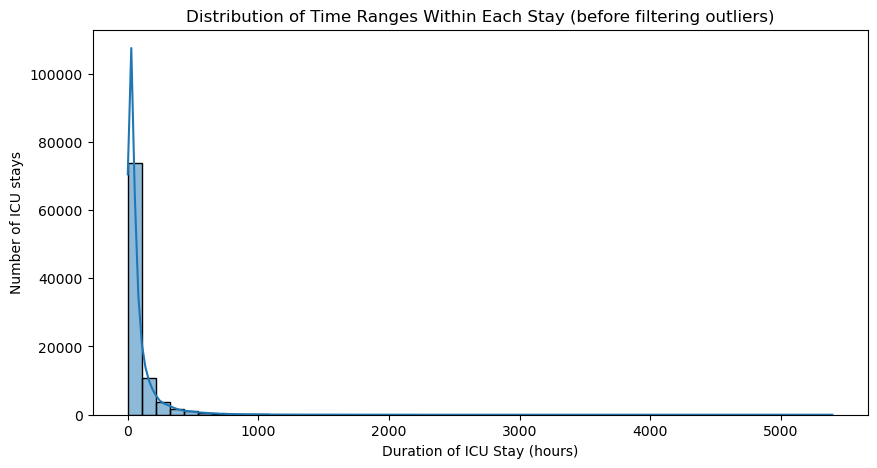

In [10]:
plt.figure(figsize=(10, 5))
sns.histplot(time_diffs_hours, bins=50, kde=True)
plt.xlabel("Duration of ICU Stay (hours)")
plt.ylabel("Number of ICU stays")
plt.title("Distribution of Time Ranges Within Each Stay (before filtering outliers)")
plt.show()

In [11]:
# Remove only higher outliers using IQR rule. The code in cells below can handle single value ICU stays.
filtered_diffs = time_diffs_hours[
    (time_diffs_hours <= time_diffs_hours.quantile(0.75) + 
     1.5 * (time_diffs_hours.quantile(0.75) - time_diffs_hours.quantile(0.25)))
]

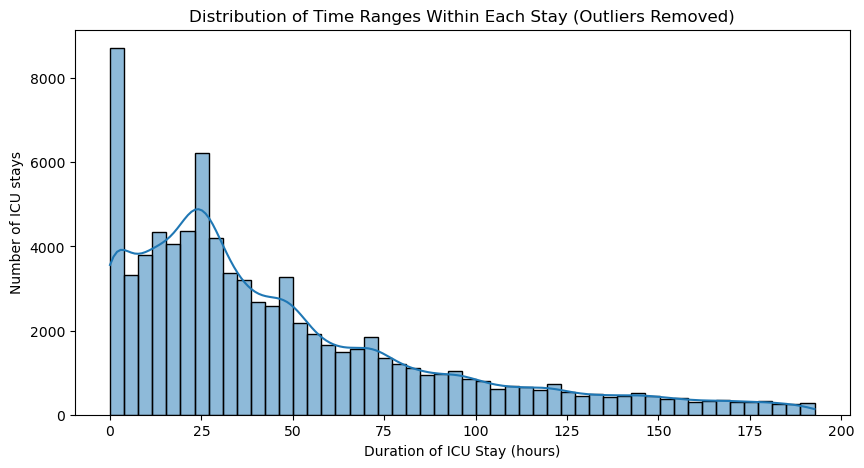

In [12]:
plt.figure(figsize=(10, 5))
sns.histplot(filtered_diffs, bins=50, kde=True)
plt.xlabel("Duration of ICU Stay (hours)")
plt.ylabel("Number of ICU stays")
plt.title("Distribution of Time Ranges Within Each Stay (Outliers Removed)")
plt.show()

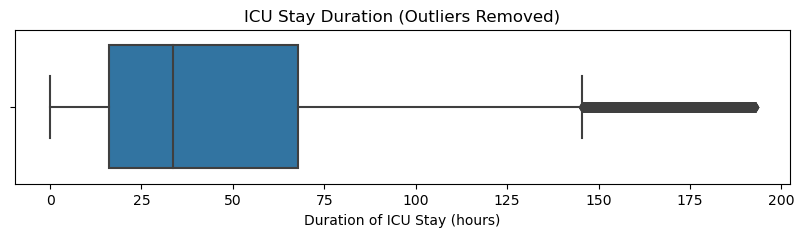

In [13]:
plt.figure(figsize=(10, 2))
sns.boxplot(x=filtered_diffs)
plt.xlabel("Duration of ICU Stay (hours)")
plt.title("ICU Stay Duration (Outliers Removed)")
plt.show()

It seems a horizon length of 70 hours is suitable, as it accommodates all values below the 3rd quartile. This means all measurements within 70 hours of the first measurement (of any type) of an ICU stay will be considered in training.

### Hyperparameters

In [6]:
FREQ       = '2H'           # 2-hour bins
MAX_HOURS  = 70              # Use 70 hours as per the earlier EDA on ICU stay lengths
STEPS      = MAX_HOURS // 2  # 70 h ÷ 2 h = 35 bins
L          = 6               # look-back  steps (12 hours of history)
H          = 1               # look-ahead steps (direct subsequent prediction)
SENTINEL   = -999.0            # value the Masking layer will ignore
HYPER_LIMIT= 180             # Lowest value to be considered hyperglycemic
HYPO_LIMIT = 70              # Highest value to be considered hypoglycemic

### Here we resample the data to ensure there is a row for every timestep interval of 2 hours.

In [18]:
def resample_stay_multi(stay_id, dfs_by_feat):

    mat = np.full((STEPS, F), np.nan, dtype='float32')

    # Find earliest timestamp amongst all features
    start_time = None
    # Visit all feature dataframes one by one, and keep track of earliest recorded time
    for df in dfs_by_feat.values():
        s = df.loc[df['stay_id'] == stay_id, 'charttime']
        if not s.empty:
            t0 = s.min()
            start_time = t0 if start_time is None else min(start_time, t0)

    # Return None if none of the feature dfs have the stay_id
    if start_time is None:
        return None

    # Standardise horizon length of icu stay measurements
    horizon = pd.date_range(start=start_time.floor(FREQ),
                            periods=STEPS,
                            freq=FREQ)

    # Fill one column of matrix per feature
    for j, feat in enumerate(FEATURES):
        g = dfs_by_feat[feat]
        g = g[g['stay_id'] == stay_id]
        if g.empty:
          # Column remains NaNs
            continue
        s = (g.set_index('charttime')['value']
               .resample(FREQ).mean())
        # reindex sets length of values to be exactly STEPS length long,
        # by trancating or padding with NaNs
        mat[:, j] = s.reindex(horizon).values

    return mat                       # (STEPS, F)

Here we create the data to be fed into the model. Each row of data in the X datasets is a sequence of BG measurements. The Y datasets contain a BG reading that follows directly from that sequence after.

The approach we took is so that a sequence of measurements (starting from the first) is created of certain length from each ICU admission, which is taken as the X, and the following value after the sequence is taken as the Y. Then the window is slid over by one so that the sequence is slightly different, creating a new X value and a new following Y value. This process is repeated until the end of the ICU admission measurement sequence is reached, then a new ICU admission is chosen, until all ICU admissions have had their sequences recorded.

We also allow the data to be split into 2 parts if a decompensation event occurred. If the before_decomp variable is true, then it takes the data from before the first decompensation and puts it in the training data. Otherwise it uses the latter half. This is to ensure that one LSTM model is trained on pre-decompensation data and another is trained on post-decompensation data.

In [19]:
def make_Xy_multi(subj_ids, fit_scaler=False, scaler_dict=None, before_decomp=True):
    X_stays = []

    # Create dictionary of all feature dataframes for the current split
    dfs_by_feat = {}
    for feat, df in MEAS_CLEAN.items():
        df_ = df[df['subject_id'].isin(subj_ids)].copy()
        df_['charttime'] = pd.to_datetime(df_['charttime'])
        
        # Here we change data to use before first decompensation or after
        if feat == 'bg':
            
            filtered_stays = []  # list to collect filtered DataFrames
            
            for stay_id in df_['stay_id'].unique():
                stay = df_[df_['stay_id'] == stay_id].sort_values(by=['charttime']).reset_index(drop=True)
                
                condition = (stay['value'] >= HYPER_LIMIT) | (stay['value'] <= HYPO_LIMIT)
                if condition.any():
                    decomp = condition.idxmax()  # gets the index of the first True value
                    # If before_decomp is true, then select all rows or measurements occurring before the first decompensation
                    if before_decomp:
                        filtered_stays.append(stay.iloc[:decomp + 1])
                    else:
                    # Otherwise after
                        filtered_stays.append(stay.iloc[decomp + 1:])
                else:
                    filtered_stays.append(stay)
            # Combine the generated dataframe and set it as the BG dataframe
            df_ = pd.concat(filtered_stays, ignore_index=True)
        dfs_by_feat[feat] = df_

    # Retrieve all unique stay_ids across all feature dataframes
    all_stays = pd.concat([d[['stay_id']] for d in dfs_by_feat.values()]
                          ).drop_duplicates()['stay_id'].values
    # Creates a list of (STEPS, F) matrices
    for sid in all_stays:
        M = resample_stay_multi(sid, dfs_by_feat)   # (STEPS, F) or None
        # Only append the matrix if at least one of the dataframes contains a value
        if M is not None:
            X_stays.append(M)

    # Convert to list of stays to 3D tensor shape
    X_stays = np.stack(X_stays)          # (N_stays, STEPS, F)

    # Feature-wise Standardisation
    if scaler_dict is None:
        scaler_dict = {}
    for j in range(F):
        # Concatenate all feature j columns across all stays, include every row, stack them
        col = X_stays[:, :, j].ravel()
        # NaN mask
        mask = ~np.isnan(col)
        if fit_scaler:
            mu = np.nanmean(col)
            sd = np.nanstd(col)
            # Protects program from division-by-zero error by ensuring if col is all NaNs, 0 is replaced with 1
            sd = sd if sd != 0 else 1.0
            scaler_dict[j] = (mu, sd)
        # Retrieves values for std and mean for when non-training splits are scaled
        mu, sd = scaler_dict[j]
        # Scales non-NaN data
        col[mask] = (col[mask] - mu) / sd

        # Sets a slice of dimension (X_stays.shape[0], STEPS) of a particular feature to the col variable
        X_stays[:, :, j] = col.reshape(X_stays.shape[0], STEPS)

    # Sliding window
    windows, targets = [], []
    for stay in X_stays:
        # Window slides across every point so that the entire horizon of the ICU stay is included once
        for t0 in range(0, STEPS - L - H + 1):
            x_win = stay[t0 : t0 + L, :]                # Look-back window
            y_val = stay[t0 + L + H - 1, GLU_IDX]       # Glucose value following window
            if not np.isnan(y_val):                     # ensure that the final y value is an actual value
                windows.append(x_win)
                targets.append(y_val)

    X = np.array(windows, dtype='float32')             # (N, L, F)
    y = np.array(targets, dtype='float32')             # (N,)

    # mask NaN timesteps
    X[np.isnan(X)] = SENTINEL
    return X, y, scaler_dict

In [20]:
os.makedirs('Pickles', exist_ok=True)

In [21]:
X_train_before, y_train_before, SCALERS_BEFORE = make_Xy_multi(SPLIT['train'], fit_scaler=True, before_decomp=True)

# Save train data and scalers immediately
train_before_path = 'Pickles/split_before_glu_train.pkl.gz'
with gzip.open(train_before_path, 'wb') as f:
    pickle.dump({
        'X_train': X_train_before,
        'y_train': y_train_before,
        'scalers': SCALERS_BEFORE
    }, f, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Saved train_before set -> {os.path.getsize(train_before_path)/1e6:.1f} MB")

Saved train_before set -> 6.0 MB


In [33]:
X_train_after, y_train_after, SCALERS_AFTER = make_Xy_multi(SPLIT['train'], fit_scaler=True, before_decomp=False)

# Save train data and scalers immediately
train_after_path = 'Pickles/split_after_glu_train.pkl.gz'
with gzip.open(train_after_path, 'wb') as f:
    pickle.dump({
        'X_train': X_train_after,
        'y_train': y_train_after,
        'scalers': SCALERS_AFTER
    }, f, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Saved train_before set -> {os.path.getsize(train_after_path)/1e6:.1f} MB")

Saved train_before set -> 11.2 MB


In [22]:
X_val_before, y_val_before, _ = make_Xy_multi(SPLIT['val'], scaler_dict=SCALERS_BEFORE, before_decomp=True)

# Save val data immediately
val_path_before = 'Pickles/split_before_glu_val.pkl.gz'
with gzip.open(val_path_before, 'wb') as f:
    pickle.dump({
        'X_val': X_val_before,
        'y_val': y_val_before
    }, f, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Saved validation set -> {os.path.getsize(val_path_before)/1e6:.1f} MB")


Saved validation set -> 2.0 MB


In [34]:
X_val_after, y_val_after, _ = make_Xy_multi(SPLIT['val'], scaler_dict=SCALERS_AFTER, before_decomp=False)

# Save val data immediately
val_path_after = 'Pickles/split_after_glu_val.pkl.gz'
with gzip.open(val_path_after, 'wb') as f:
    pickle.dump({
        'X_val': X_val_after,
        'y_val': y_val_after
    }, f, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Saved validation set -> {os.path.getsize(val_path_after)/1e6:.1f} MB")

Saved validation set -> 3.8 MB


In [23]:
X_test_before, y_test_before, _ = make_Xy_multi(SPLIT['test'], scaler_dict=SCALERS_BEFORE, before_decomp=True)

# Save test data immediately
test_path_before = 'Pickles/split_before_glu_test.pkl.gz'
with gzip.open(test_path_before, 'wb') as f:
    pickle.dump({
        'X_test': X_test_before,
        'y_test': y_test_before
    }, f, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Saved test set -> {os.path.getsize(test_path_before)/1e6:.1f} MB")

Saved test set -> 2.0 MB


In [35]:
X_test_after, y_test_after, _ = make_Xy_multi(SPLIT['test'], scaler_dict=SCALERS_AFTER, before_decomp=False)

# Save test data immediately
test_path_after = 'Pickles/split_after_glu_test.pkl.gz'
with gzip.open(test_path_after, 'wb') as f:
    pickle.dump({
        'X_test': X_test_after,
        'y_test': y_test_after
    }, f, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Saved test set -> {os.path.getsize(test_path_after)/1e6:.1f} MB")

Saved test set -> 3.7 MB


In [69]:
# After you build SCALERS in make_Xy_multi
mu_glu_before, std_glu_before = SCALERS_BEFORE[GLU_IDX]          
print(f"Glucose  μ={mu_glu_before:.1f}  σ={std_glu_before:.1f}")


Glucose  μ=130.6  σ=50.8


In [70]:
# After you build SCALERS in make_Xy_multi
mu_glu_after, std_glu_after = SCALERS_AFTER[GLU_IDX]         
print(f"Glucose  μ={mu_glu_after:.1f}  σ={std_glu_after:.1f}")


Glucose  μ=148.2  σ=62.6


In [37]:
print("--------Pre-Decomp--------")
print("Train:", X_train_before.shape, y_train_before.shape)
print("Val  :", X_val_before.shape,   y_val_before.shape)
print("Test :", X_test_before.shape,  y_test_before.shape)
print("--------Post-Decomp--------")
print("Train:", X_train_after.shape, y_train_after.shape)
print("Val  :", X_val_after.shape,   y_val_after.shape)
print("Test :", X_test_after.shape,  y_test_after.shape)

--------Pre-Decomp--------
Train: (137914, 6, 10) (137914,)
Val  : (46103, 6, 10) (46103,)
Test : (45965, 6, 10) (45965,)
--------Post-Decomp--------
Train: (290442, 6, 10) (290442,)
Val  : (97896, 6, 10) (97896,)
Test : (96863, 6, 10) (96863,)


In [38]:
print("Any NaN in y_train_before ?", np.isnan(y_train_before).any())
print("Any NaN in X_train_before ?", np.isnan(X_train_before).any())

print("Any NaN in y_train_after ?", np.isnan(y_train_after).any())
print("Any NaN in X_train_after ?", np.isnan(X_train_after).any())
# How many?
print("NaN count (before):", np.isnan(X_train_before).sum())
print("NaN count (after):", np.isnan(X_train_after).sum())

Any NaN in y_train_before ? False
Any NaN in X_train_before ? False
Any NaN in y_train_after ? False
Any NaN in X_train_after ? False
NaN count (before): 0
NaN count (after): 0


In [7]:
BATCH = 64
def make_ds(X, y, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(len(y), seed=seed)
    return ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)

In [39]:
ds_train_before = make_ds(X_train_before, y_train_before, shuffle=True)
ds_val_before   = make_ds(X_val_before,   y_val_before,   shuffle=False)
ds_test_before  = make_ds(X_test_before,  y_test_before,  shuffle=False)

ds_train_after = make_ds(X_train_after, y_train_after, shuffle=True)
ds_val_after   = make_ds(X_val_after,   y_val_after,   shuffle=False)
ds_test_after  = make_ds(X_test_after,  y_test_after,  shuffle=False)

# Pre-decompensation LSTM model

Below here we train a LSTM model using data from before a patient's first decompensation.

In [30]:
model_before = tf.keras.Sequential([
    tf.keras.layers.Masking(mask_value=SENTINEL, input_shape=(L, F)),
    tf.keras.layers.LSTM(64),
    # A dense layer here is necessary, as each hidden state output, which is
    # the output of an LSTM unit is only within the range of a tanh activation function,
    # so further transformation is needed
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)                   # regression
])

model_before.compile(loss='mse', optimizer='adam', metrics=['mae', RootMeanSquaredError(name='rmse'), 'mse'])
model_before.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 6, 10)             0         
                                                                 
 lstm (LSTM)                 (None, 64)                19200     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Create directory if it doesn't exist
os.makedirs('models', exist_ok=True)

In [31]:
#  Create a checkpoint callback
ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath='models/preDecomp_multivar_epoch_{epoch:02d}.h5',
    save_freq='epoch',                        # save after each epoch
    save_weights_only=False,                  # save the entire model (architecture + weights + optimizer state)
    verbose=1)

history_before = model_before.fit(
    ds_train_before,
    epochs=100,
    # Validation is used to determine if model is overfitting
    validation_data=ds_val_before,
    callbacks=[ckpt],
    verbose=1
)

results = model_before.evaluate(ds_test_before, return_dict=True)
print(f"Test RMSE = {results['rmse']:.2f}   |   MAE = {results['mae']:.2f}")

Epoch 1/100
2144/2155 [============================>.] - ETA: 0s - loss: 0.5085 - mae: 0.4615 - rmse: 0.7131 - mse: 0.5085
Epoch 1: saving model to models\preDecomp_multivar_epoch_01.h5
2155/2155 [==============================] - 12s 4ms/step - loss: 0.5076 - mae: 0.4614 - rmse: 0.7124 - mse: 0.5076 - val_loss: 0.4780 - val_mae: 0.4617 - val_rmse: 0.6913 - val_mse: 0.4780
Epoch 2/100
2151/2155 [============================>.] - ETA: 0s - loss: 0.5032 - mae: 0.4585 - rmse: 0.7093 - mse: 0.5032
Epoch 2: saving model to models\preDecomp_multivar_epoch_02.h5
2155/2155 [==============================] - 9s 4ms/step - loss: 0.5037 - mae: 0.4586 - rmse: 0.7097 - mse: 0.5037 - val_loss: 0.4778 - val_mae: 0.4575 - val_rmse: 0.6912 - val_mse: 0.4778
Epoch 3/100
2154/2155 [============================>.] - ETA: 0s - loss: 0.5040 - mae: 0.4588 - rmse: 0.7100 - mse: 0.5040
Epoch 3: saving model to models\preDecomp_multivar_epoch_03.h5
2155/2155 [==============================] - 10s 4ms/step - los

Epoch 23/100
2149/2155 [============================>.] - ETA: 0s - loss: 0.4994 - mae: 0.4546 - rmse: 0.7067 - mse: 0.4994
Epoch 23: saving model to models\preDecomp_multivar_epoch_23.h5
2155/2155 [==============================] - 15s 7ms/step - loss: 0.4997 - mae: 0.4546 - rmse: 0.7069 - mse: 0.4997 - val_loss: 0.4748 - val_mae: 0.4529 - val_rmse: 0.6891 - val_mse: 0.4748
Epoch 24/100
2153/2155 [============================>.] - ETA: 0s - loss: 0.5003 - mae: 0.4550 - rmse: 0.7073 - mse: 0.5003
Epoch 24: saving model to models\preDecomp_multivar_epoch_24.h5
2155/2155 [==============================] - 14s 7ms/step - loss: 0.5001 - mae: 0.4550 - rmse: 0.7072 - mse: 0.5001 - val_loss: 0.4760 - val_mae: 0.4530 - val_rmse: 0.6899 - val_mse: 0.4760
Epoch 25/100
2152/2155 [============================>.] - ETA: 0s - loss: 0.5006 - mae: 0.4551 - rmse: 0.7076 - mse: 0.5006
Epoch 25: saving model to models\preDecomp_multivar_epoch_25.h5
2155/2155 [==============================] - 15s 7ms/ste

Epoch 45/100
2151/2155 [============================>.] - ETA: 0s - loss: 0.5008 - mae: 0.4557 - rmse: 0.7077 - mse: 0.5008
Epoch 45: saving model to models\preDecomp_multivar_epoch_45.h5
2155/2155 [==============================] - 14s 7ms/step - loss: 0.5007 - mae: 0.4557 - rmse: 0.7076 - mse: 0.5007 - val_loss: 0.4753 - val_mae: 0.4550 - val_rmse: 0.6894 - val_mse: 0.4753
Epoch 46/100
2154/2155 [============================>.] - ETA: 0s - loss: 0.5001 - mae: 0.4555 - rmse: 0.7072 - mse: 0.5001
Epoch 46: saving model to models\preDecomp_multivar_epoch_46.h5
2155/2155 [==============================] - 14s 6ms/step - loss: 0.5003 - mae: 0.4556 - rmse: 0.7074 - mse: 0.5003 - val_loss: 0.4754 - val_mae: 0.4574 - val_rmse: 0.6895 - val_mse: 0.4754
Epoch 47/100
2150/2155 [============================>.] - ETA: 0s - loss: 0.5008 - mae: 0.4556 - rmse: 0.7077 - mse: 0.5008
Epoch 47: saving model to models\preDecomp_multivar_epoch_47.h5
2155/2155 [==============================] - 15s 7ms/ste

Epoch 67/100
2148/2155 [============================>.] - ETA: 0s - loss: 0.4985 - mae: 0.4549 - rmse: 0.7061 - mse: 0.4985
Epoch 67: saving model to models\preDecomp_multivar_epoch_67.h5
2155/2155 [==============================] - 14s 6ms/step - loss: 0.4996 - mae: 0.4549 - rmse: 0.7068 - mse: 0.4996 - val_loss: 0.4751 - val_mae: 0.4580 - val_rmse: 0.6893 - val_mse: 0.4751
Epoch 68/100
2153/2155 [============================>.] - ETA: 0s - loss: 0.4997 - mae: 0.4550 - rmse: 0.7069 - mse: 0.4997
Epoch 68: saving model to models\preDecomp_multivar_epoch_68.h5
2155/2155 [==============================] - 13s 6ms/step - loss: 0.4995 - mae: 0.4550 - rmse: 0.7068 - mse: 0.4995 - val_loss: 0.4747 - val_mae: 0.4564 - val_rmse: 0.6890 - val_mse: 0.4747
Epoch 69/100
2147/2155 [============================>.] - ETA: 0s - loss: 0.4995 - mae: 0.4548 - rmse: 0.7067 - mse: 0.4995
Epoch 69: saving model to models\preDecomp_multivar_epoch_69.h5
2155/2155 [==============================] - 13s 6ms/ste

Epoch 89/100
2148/2155 [============================>.] - ETA: 0s - loss: 0.4983 - mae: 0.4532 - rmse: 0.7059 - mse: 0.4983
Epoch 89: saving model to models\preDecomp_multivar_epoch_89.h5
2155/2155 [==============================] - 14s 6ms/step - loss: 0.4980 - mae: 0.4531 - rmse: 0.7057 - mse: 0.4980 - val_loss: 0.4749 - val_mae: 0.4578 - val_rmse: 0.6891 - val_mse: 0.4749
Epoch 90/100
2149/2155 [============================>.] - ETA: 0s - loss: 0.4977 - mae: 0.4533 - rmse: 0.7055 - mse: 0.4977
Epoch 90: saving model to models\preDecomp_multivar_epoch_90.h5
2155/2155 [==============================] - 14s 7ms/step - loss: 0.4981 - mae: 0.4532 - rmse: 0.7057 - mse: 0.4981 - val_loss: 0.4746 - val_mae: 0.4544 - val_rmse: 0.6889 - val_mse: 0.4746
Epoch 91/100
2153/2155 [============================>.] - ETA: 0s - loss: 0.4980 - mae: 0.4531 - rmse: 0.7057 - mse: 0.4980
Epoch 91: saving model to models\preDecomp_multivar_epoch_91.h5
2155/2155 [==============================] - 14s 7ms/ste

In [32]:
y_pred_z = model_before.predict(ds_test_before, verbose=0).ravel()   # z-scores
y_true_z = y_test_before

# inverse-transform back to mg/dL
y_pred_before = y_pred_z * std_glu_before + mu_glu_before
y_true_before = y_true_z * std_glu_before + mu_glu_before

# metrics in true units
mse  = np.mean((y_true - y_pred) ** 2)    
rmse = np.sqrt(mse)
mae  = np.mean(np.abs(y_true - y_pred))
r2 = r2_score(y_true, y_pred)

print(f"Test MSE  = {mse :.2f} (mg/dL)^2")
print(f"Test RMSE = {rmse:.2f} mg/dL")
print(f"Test MAE  = {mae :.2f} mg/dL")
print(f"Test R^2  = {r2:.4f}")

Test MSE  = 1520.90 (mg/dL)^2
Test RMSE = 39.00 mg/dL
Test MAE  = 23.31 mg/dL
Test R^2 = 0.0096


## Pre-Decompensation Classification Metrics

Below we convert to classification metrics for the pre-decompensation model so we can compare to other models.

In [44]:
def convert_categorical(y):
    y_class = np.full((len(y)), "unknown", dtype='U10')
    y_hypo_mask = y <= 70
    y_hyper_mask = y >= 180
    y_normal_mask = (y > 70) & (y < 180)
    y_class[y_hypo_mask] = "Hypo"
    y_class[y_hyper_mask] = "Hyper"
    y_class[y_normal_mask] = "Normal"
    return y_class

In [43]:
y_pred_z = model_before.predict(ds_test_before, verbose=0).ravel()   # z-scores
y_true_z = y_test_before
mu_glu_before, std_glu_before = SCALERS_BEFORE[1]          # index 1 is BG scale values

# inverse-transform back to mg/dL
y_pred = y_pred_z * std_glu_before + mu_glu_before
y_true = y_true_z * std_glu_before + mu_glu_before

In [45]:
y_pred_class = convert_categorical(y_pred)
y_true_class = convert_categorical(y_true)

In [46]:
le = LabelEncoder()
y_true_encoded = le.fit_transform(y_true_class)  # e.g. 'Hypo'=0, 'Normal'=1, 'Hyper'=2
y_pred_encoded = le.transform(y_pred_class)

In [47]:
# Full classification metrics
print(classification_report(y_true_encoded, y_pred_encoded, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_true_encoded, y_pred_encoded)
print("Confusion Matrix:\n", cm)

              precision    recall  f1-score   support

       Hyper       0.14      0.00      0.00      2097
        Hypo       0.00      0.00      0.00       557
      Normal       0.94      1.00      0.97     43311

    accuracy                           0.94     45965
   macro avg       0.36      0.33      0.32     45965
weighted avg       0.89      0.94      0.91     45965

Confusion Matrix:
 [[    1     0  2096]
 [    0     0   557]
 [    6     0 43305]]


C:\Users\Mashal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mashal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mashal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
# One-hot encode
y_true_bin = label_binarize(y_true_encoded, classes=[0,1,2])
y_pred_bin = label_binarize(y_pred_encoded, classes=[0,1,2])

# Macro-average AUC
auc_macro = roc_auc_score(y_true_bin, y_pred_bin, average='macro', multi_class='ovo')
print(f"Macro-average AUC-ROC: {auc_macro:.4f}")

Macro-average AUC-ROC: 0.5001


### Pre-decompensation model extra testing

Below we test the pre-decompensation model on the full dataset. The testing variables that are loaded via pickle are created by the "Multivariate Resampled LSTM Model.ipynb" file in the GitHub.

In [80]:
test_path = 'Pickles/filtered_glu_test.pkl.gz'
with gzip.open(test_path, 'rb') as f:
    test_data = pickle.load(f)

X_test = test_data['X_test']
y_test = test_data['y_test']

train_path = 'Pickles/filtered_glu_train.pkl.gz'
with gzip.open(train_path, 'rb') as f:
    train_data = pickle.load(f)
    
SCALERS  = train_data['scalers']

In [82]:
ds_test  = make_ds(X_test,  y_test,  shuffle=False)

In [83]:
y_pred_z = model_before.predict(ds_test, verbose=0).ravel()   # z-scores
y_true_z = y_test

# inverse-transform back to mg/dL
y_pred_all = y_pred_z * std_glu_before + mu_glu_before
y_true_all= y_true_z * std_glu_before + mu_glu_before

# metrics in true units
mse  = np.mean((y_true_all - y_pred_all) ** 2)    
rmse = np.sqrt(mse)
mae  = np.mean(np.abs(y_true_all - y_pred_all))
r2 = r2_score(y_true_all, y_pred_all)

print(f"Test MSE  = {mse :.2f} (mg/dL)^2")
print(f"Test RMSE = {rmse:.2f} mg/dL")
print(f"Test MAE  = {mae :.2f} mg/dL")
print(f"Test R^2  = {r2:.4f}")

Test MSE  = 2210.36 (mg/dL)^2
Test RMSE = 47.01 mg/dL
Test MAE  = 31.08 mg/dL
Test R^2  = 0.0094


We can see this model performs much better than the multivariate model in "Multivariate Resampled LSTM Model.ipynb".

#### Classification Metrics

In [91]:
y_pred_class = convert_categorical(y_pred_all)
y_true_class = convert_categorical(y_true_all)

le = LabelEncoder()
y_true_encoded = le.fit_transform(y_true_class)  # e.g. 'Hypo'=0, 'Normal'=1, 'Hyper'=2
y_pred_encoded = le.transform(y_pred_class)

# Full classification metrics
print(classification_report(y_true_encoded, y_pred_encoded, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_true_encoded, y_pred_encoded)
print("Confusion Matrix:\n", cm)

# One-hot encode
y_true_bin = label_binarize(y_true_encoded, classes=[0,1,2])
y_pred_bin = label_binarize(y_pred_encoded, classes=[0,1,2])

# Macro-average AUC
auc_macro = roc_auc_score(y_true_bin, y_pred_bin, average='macro', multi_class='ovo')
print(f"\nMacro-average AUC-ROC: {auc_macro:.4f}")

              precision    recall  f1-score   support

       Hyper       0.46      0.00      0.00      9470
        Hypo       0.00      0.00      0.00      1299
      Normal       0.87      1.00      0.93     73994

    accuracy                           0.87     84763
   macro avg       0.44      0.33      0.31     84763
weighted avg       0.81      0.87      0.81     84763

Confusion Matrix:
 [[    6     0  9464]
 [    0     0  1299]
 [    7     1 73986]]

Macro-average AUC-ROC: 0.5002


# Post-decompensation LSTM model

Below here we train a LSTM model using data from after a patient's first decompensation.

In [40]:
model_after = tf.keras.Sequential([
    tf.keras.layers.Masking(mask_value=SENTINEL, input_shape=(L, F)),
    tf.keras.layers.LSTM(64),
    # A dense layer here is necessary, as each hidden state output, which is
    # the output of an LSTM unit is only within the range of a tanh activation function,
    # so further transformation is needed
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)                   # regression
])

model_after.compile(loss='mse', optimizer='adam', metrics=['mae', RootMeanSquaredError(name='rmse'), 'mse'])
model_after.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_1 (Masking)         (None, 6, 10)             0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                19200     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________


In [57]:
#  Create a checkpoint callback
ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath='models/postDecomp_multivar_epoch_{epoch:02d}.h5',
    save_freq='epoch',                        # save after each epoch
    save_weights_only=False,                  # save the entire model (architecture + weights + optimizer state)
    verbose=1)

history_after = model_after.fit(
    ds_train_after,
    epochs=100,
    # Validation is used to determine if model is overfitting
    validation_data=ds_val_after,
    callbacks=[ckpt],
    verbose=1
)

results = model_after.evaluate(ds_test_after, return_dict=True)
print(f"Test RMSE = {results['rmse']:.2f}   |   MAE = {results['mae']:.2f}")

Epoch 1/100
4536/4539 [============================>.] - ETA: 0s - loss: 0.8670 - mae: 0.6629 - rmse: 0.9311 - mse: 0.8670
Epoch 1: saving model to models\postDecomp_multivar_epoch_01.h5
4539/4539 [==============================] - 61s 13ms/step - loss: 0.8669 - mae: 0.6629 - rmse: 0.9311 - mse: 0.8669 - val_loss: 0.8925 - val_mae: 0.6687 - val_rmse: 0.9447 - val_mse: 0.8925
Epoch 2/100
4537/4539 [============================>.] - ETA: 0s - loss: 0.8586 - mae: 0.6589 - rmse: 0.9266 - mse: 0.8586
Epoch 2: saving model to models\postDecomp_multivar_epoch_02.h5
4539/4539 [==============================] - 62s 14ms/step - loss: 0.8586 - mae: 0.6589 - rmse: 0.9266 - mse: 0.8586 - val_loss: 0.8953 - val_mae: 0.6736 - val_rmse: 0.9462 - val_mse: 0.8953
Epoch 3/100
4537/4539 [============================>.] - ETA: 0s - loss: 0.8615 - mae: 0.6607 - rmse: 0.9282 - mse: 0.8615
Epoch 3: saving model to models\postDecomp_multivar_epoch_03.h5
4539/4539 [==============================] - 56s 12ms/ste

Epoch 23/100
4535/4539 [============================>.] - ETA: 0s - loss: 0.8483 - mae: 0.6546 - rmse: 0.9210 - mse: 0.8483
Epoch 23: saving model to models\postDecomp_multivar_epoch_23.h5
4539/4539 [==============================] - 60s 13ms/step - loss: 0.8483 - mae: 0.6545 - rmse: 0.9210 - mse: 0.8483 - val_loss: 0.8878 - val_mae: 0.6654 - val_rmse: 0.9422 - val_mse: 0.8878
Epoch 24/100
4535/4539 [============================>.] - ETA: 0s - loss: 0.8480 - mae: 0.6542 - rmse: 0.9209 - mse: 0.8480
Epoch 24: saving model to models\postDecomp_multivar_epoch_24.h5
4539/4539 [==============================] - 61s 13ms/step - loss: 0.8482 - mae: 0.6543 - rmse: 0.9210 - mse: 0.8482 - val_loss: 0.8869 - val_mae: 0.6613 - val_rmse: 0.9418 - val_mse: 0.8869
Epoch 25/100
4537/4539 [============================>.] - ETA: 0s - loss: 0.8485 - mae: 0.6543 - rmse: 0.9212 - mse: 0.8485
Epoch 25: saving model to models\postDecomp_multivar_epoch_25.h5
4539/4539 [==============================] - 61s 13

Epoch 45/100
4536/4539 [============================>.] - ETA: 0s - loss: 0.8446 - mae: 0.6519 - rmse: 0.9190 - mse: 0.8446
Epoch 45: saving model to models\postDecomp_multivar_epoch_45.h5
4539/4539 [==============================] - 64s 14ms/step - loss: 0.8446 - mae: 0.6519 - rmse: 0.9190 - mse: 0.8446 - val_loss: 0.8840 - val_mae: 0.6580 - val_rmse: 0.9402 - val_mse: 0.8840
Epoch 46/100
4535/4539 [============================>.] - ETA: 0s - loss: 0.8436 - mae: 0.6515 - rmse: 0.9185 - mse: 0.8436
Epoch 46: saving model to models\postDecomp_multivar_epoch_46.h5
4539/4539 [==============================] - 64s 14ms/step - loss: 0.8436 - mae: 0.6515 - rmse: 0.9185 - mse: 0.8436 - val_loss: 0.8830 - val_mae: 0.6572 - val_rmse: 0.9397 - val_mse: 0.8830
Epoch 47/100
4535/4539 [============================>.] - ETA: 0s - loss: 0.8428 - mae: 0.6508 - rmse: 0.9181 - mse: 0.8428
Epoch 47: saving model to models\postDecomp_multivar_epoch_47.h5
4539/4539 [==============================] - 64s 14

Epoch 67/100
4537/4539 [============================>.] - ETA: 0s - loss: 0.8417 - mae: 0.6505 - rmse: 0.9175 - mse: 0.8417
Epoch 67: saving model to models\postDecomp_multivar_epoch_67.h5
4539/4539 [==============================] - 64s 14ms/step - loss: 0.8417 - mae: 0.6505 - rmse: 0.9174 - mse: 0.8417 - val_loss: 0.8837 - val_mae: 0.6645 - val_rmse: 0.9400 - val_mse: 0.8837
Epoch 68/100
4536/4539 [============================>.] - ETA: 0s - loss: 0.8426 - mae: 0.6509 - rmse: 0.9179 - mse: 0.8426
Epoch 68: saving model to models\postDecomp_multivar_epoch_68.h5
4539/4539 [==============================] - 64s 14ms/step - loss: 0.8424 - mae: 0.6509 - rmse: 0.9178 - mse: 0.8424 - val_loss: 0.8850 - val_mae: 0.6595 - val_rmse: 0.9408 - val_mse: 0.8850
Epoch 69/100
4535/4539 [============================>.] - ETA: 0s - loss: 0.8421 - mae: 0.6508 - rmse: 0.9176 - mse: 0.8421
Epoch 69: saving model to models\postDecomp_multivar_epoch_69.h5
4539/4539 [==============================] - 64s 14

Epoch 89/100
4537/4539 [============================>.] - ETA: 0s - loss: 0.8441 - mae: 0.6522 - rmse: 0.9187 - mse: 0.8441
Epoch 89: saving model to models\postDecomp_multivar_epoch_89.h5
4539/4539 [==============================] - 64s 14ms/step - loss: 0.8441 - mae: 0.6522 - rmse: 0.9188 - mse: 0.8441 - val_loss: 0.8856 - val_mae: 0.6569 - val_rmse: 0.9411 - val_mse: 0.8856
Epoch 90/100
4537/4539 [============================>.] - ETA: 0s - loss: 0.8444 - mae: 0.6522 - rmse: 0.9189 - mse: 0.8444
Epoch 90: saving model to models\postDecomp_multivar_epoch_90.h5
4539/4539 [==============================] - 64s 14ms/step - loss: 0.8444 - mae: 0.6522 - rmse: 0.9189 - mse: 0.8444 - val_loss: 0.8852 - val_mae: 0.6639 - val_rmse: 0.9408 - val_mse: 0.8852
Epoch 91/100
4537/4539 [============================>.] - ETA: 0s - loss: 0.8448 - mae: 0.6522 - rmse: 0.9191 - mse: 0.8448
Epoch 91: saving model to models\postDecomp_multivar_epoch_91.h5
4539/4539 [==============================] - 64s 14

In [58]:
y_pred_z = model_after.predict(ds_test_after, verbose=0).ravel()   # z-scores
y_true_z = y_test_after

# inverse-transform back to mg/dL
y_pred_after = y_pred_z * std_glu_after + mu_glu_after
y_true_after = y_true_z * std_glu_after + mu_glu_after

# metrics in true units
mse  = np.mean((y_true - y_pred) ** 2)    
rmse = np.sqrt(mse)
mae  = np.mean(np.abs(y_true - y_pred))
r2 = r2_score(y_true, y_pred)

print(f"Test MSE  = {mse :.2f} (mg/dL)^2")
print(f"Test RMSE = {rmse:.2f} mg/dL")
print(f"Test MAE  = {mae :.2f} mg/dL")
print(f"Test R^2  = {r2:.4f}")

Test MSE  = 4022.36 (mg/dL)^2
Test RMSE = 63.42 mg/dL
Test MAE  = 44.11 mg/dL
Test R^2  = -0.1221


# Post-Decompensation Classification Metrics

Below we convert to classification metrics for the post-decompensation model so we can compare to other models.

In [84]:
y_pred_after_z = model_after.predict(ds_test_after, verbose=0).ravel()   # z-scores
y_true_after_z = y_test_after
mu_glu_after, std_glu_after = SCALERS_AFTER[1]          # index 1 is BG scale values

# inverse-transform back to mg/dL
y_pred_after = y_pred_after_z * std_glu_after + mu_glu_after
y_true_after = y_true_after_z * std_glu_after + mu_glu_after

In [85]:
y_pred_class = convert_categorical(y_pred_after)
y_true_class = convert_categorical(y_true_after)

In [86]:
le = LabelEncoder()
y_true_encoded = le.fit_transform(y_true_class)  # e.g. 'Hypo'=0, 'Normal'=1, 'Hyper'=2
y_pred_encoded = le.transform(y_pred_class)

In [87]:
# Full classification metrics
print(classification_report(y_true_encoded, y_pred_encoded, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_true_encoded, y_pred_encoded)
print("Confusion Matrix:\n", cm)

              precision    recall  f1-score   support

       Hyper       0.43      0.01      0.01     19608
        Hypo       1.00      0.00      0.00      1064
      Normal       0.79      1.00      0.88     76191

    accuracy                           0.79     96863
   macro avg       0.74      0.33      0.30     96863
weighted avg       0.72      0.79      0.69     96863

Confusion Matrix:
 [[  108     0 19500]
 [    2     1  1061]
 [  139     0 76052]]


In [88]:
# One-hot encode
y_true_bin = label_binarize(y_true_encoded, classes=[0,1,2])
y_pred_bin = label_binarize(y_pred_encoded, classes=[0,1,2])

# Macro-average AUC
auc_macro = roc_auc_score(y_true_bin, y_pred_bin, average='macro', multi_class='ovo')
print(f"Macro-average AUC-ROC: {auc_macro:.4f}")

Macro-average AUC-ROC: 0.5014


## Testing pre-decompensation and post-decompensation models as one system

Below we test both pre-decompensation and post-decompensation models as if they were a conjoined system. So if a patient had a dysglycemic event previously, the post-decompensation model would be used. If no previous dysglycemic event occurred (in an ICU stay), then a pre-decompensation model would be used.

In [64]:
# Pre-decompensation test results
y_pred_before_z = model_before.predict(ds_test_before, verbose=0).ravel()   # z-scores
y_true_before_z = y_test_before
mu_glu_before, std_glu_before = SCALERS_BEFORE[1]          # index 1 is BG scale values

# inverse-transform back to mg/dL
y_pred_before = y_pred_before_z * std_glu_before + mu_glu_before
y_true_before = y_true_before_z * std_glu_before + mu_glu_before

# Post-decompensation test results
y_pred_after_z = model_after.predict(ds_test_after, verbose=0).ravel()   # z-scores
y_true_after_z = y_test_after
mu_glu_after, std_glu_after = SCALERS_AFTER[1]          # index 1 is BG scale values

# inverse-transform back to mg/dL
y_pred_after = y_pred_after_z * std_glu_after + mu_glu_after
y_true_after = y_true_after_z * std_glu_after + mu_glu_after

Below we combine the results so we can run testing metrics on them.

In [65]:
y_pred = np.hstack([y_pred_before, y_pred_after])
y_true = np.hstack([y_true_before, y_true_after])

In [66]:
mse  = np.mean((y_true - y_pred) ** 2)    
rmse = np.sqrt(mse)
mae  = np.mean(np.abs(y_true - y_pred))
r2 = r2_score(y_true, y_pred)

print(f"Test MSE  = {mse :.2f} (mg/dL)^2")
print(f"Test RMSE = {rmse:.2f} mg/dL")
print(f"Test MAE  = {mae :.2f} mg/dL")
print(f"Test R^2  = {r2:.4f}")

Test MSE  = 3104.24 (mg/dL)^2
Test RMSE = 55.72 mg/dL
Test MAE  = 37.19 mg/dL
Test R^2  = 0.0292


#### Classification Metrics for combined model

In [90]:
y_pred_class = convert_categorical(y_pred)
y_true_class = convert_categorical(y_true)

le = LabelEncoder()
y_true_encoded = le.fit_transform(y_true_class)  # e.g. 'Hypo'=0, 'Normal'=1, 'Hyper'=2
y_pred_encoded = le.transform(y_pred_class)

# Full classification metrics
print(classification_report(y_true_encoded, y_pred_encoded, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_true_encoded, y_pred_encoded)
print("Confusion Matrix:\n", cm)

# One-hot encode
y_true_bin = label_binarize(y_true_encoded, classes=[0,1,2])
y_pred_bin = label_binarize(y_pred_encoded, classes=[0,1,2])

# Macro-average AUC
auc_macro = roc_auc_score(y_true_bin, y_pred_bin, average='macro', multi_class='ovo')
print(f"\nMacro-average AUC-ROC: {auc_macro:.4f}")

              precision    recall  f1-score   support

       Hyper       0.43      0.00      0.01     24747
        Hypo       1.00      0.00      0.00      1424
      Normal       0.82      1.00      0.90    116657

    accuracy                           0.82    142828
   macro avg       0.75      0.33      0.30    142828
weighted avg       0.75      0.82      0.74    142828

Confusion Matrix:
 [[   110      0  24637]
 [     2      1   1421]
 [   144      0 116513]]

Macro-average AUC-ROC: 0.5012


# Hyperparameter tuning

Below we experiment with some hyperparameter tuning for the LSTM model.

In [8]:
train_path = 'Pickles/split_before_glu_train.pkl.gz'
with gzip.open(train_path, 'rb') as f:
    train_data = pickle.load(f)

X_train_gs = train_data['X_train']
y_train_gs = train_data['y_train']
SCALERS_GS  = train_data['scalers']

In [9]:
mu_glu_gs, std_glu_gs = SCALERS_GS[GLU_IDX]          

In [10]:
def build_model(lstm_units=64, dense_units=32, learning_rate=0.001):
    model = tf.keras.Sequential([
        tf.keras.layers.Masking(mask_value=SENTINEL, input_shape=(L, F)),
        tf.keras.layers.LSTM(lstm_units),
        tf.keras.layers.Dense(dense_units, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', RootMeanSquaredError(name='rmse'), 'mse'])
    return model

In [10]:
reg = KerasRegressor(build_fn=build_model, epochs=10, batch_size=32, verbose=0)

param_grid = {
    'lstm_units': [32, 64],
    'dense_units': [16, 32],
    'learning_rate': [0.001, 0.0001, 0.0005],
}

C:\Users\Mashal\AppData\Local\Temp\ipykernel_27412\725283007.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(build_fn=build_model, epochs=10, batch_size=32, verbose=0)


In [11]:
grid = GridSearchCV(estimator=reg, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_result = grid.fit(X_train_gs, y_train_gs)

In [12]:
print("Best Params:", grid_result.best_params_)
print("Best RMSE (sqrt of neg-MSE):", (-grid_result.best_score_) ** 0.5 * std_glu_gs)

Best Params: {'dense_units': 32, 'learning_rate': 0.001, 'lstm_units': 64}
Best RMSE (sqrt of neg-MSE): 35.992317032825504


In [11]:
param_grid = {
    'lstm_units': [128, 256],
    'dense_units': [32, 64, 128],
    'learning_rate': [0.001],
}

In [12]:
grid2 = GridSearchCV(estimator=reg, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_result2 = grid2.fit(X_train_gs, y_train_gs)

In [13]:
print("Best Params:", grid_result2.best_params_)
print("Best RMSE (sqrt of neg-MSE):", (-grid_result2.best_score_) ** 0.5 * std_glu_gs)

Best Params: {'dense_units': 32, 'learning_rate': 0.001, 'lstm_units': 256}
Best RMSE (sqrt of neg-MSE): 35.97127904800289


### Below we test the best gridsearch model on the full dataset

In [11]:
model_gs = build_model(256, 32, 0.001)

In [12]:
test_path = 'Pickles/filtered_glu_test.pkl.gz'
with gzip.open(test_path, 'rb') as f:
    train_data = pickle.load(f)

X_test_gs = train_data['X_test']
y_test_gs = train_data['y_test']

In [13]:
ds_test_gs  = make_ds(X_test_gs,  y_test_gs,  shuffle=False)
ds_train_gs  = make_ds(X_train_gs,  y_train_gs,  shuffle=False)

In [16]:
#  Create a checkpoint callback
ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath='models/preDecomp_gs_epoch_{epoch:02d}.h5',
    save_freq='epoch',                        # save after each epoch
    save_weights_only=False,                  # save the entire model (architecture + weights + optimizer state)
    verbose=1)

history_after = model_gs.fit(
    ds_train_gs,
    epochs=10,
    callbacks=[ckpt],
    verbose=1
)

results = model_gs.evaluate(ds_test_gs, return_dict=True)
print(f"Test RMSE = {results['rmse']:.2f}   |   MAE = {results['mae']:.2f}")

Epoch 1/10
2153/2155 [============================>.] - ETA: 0s - loss: 0.5062 - mae: 0.4597 - rmse: 0.7115 - mse: 0.5062     
Epoch 1: saving model to models\preDecomp_gs_epoch_01.h5
2155/2155 [==============================] - 30s 13ms/step - loss: 0.5062 - mae: 0.4598 - rmse: 0.7115 - mse: 0.5062
Epoch 2/10
2153/2155 [============================>.] - ETA: 0s - loss: 0.5033 - mae: 0.4579 - rmse: 0.7095 - mse: 0.5033 
Epoch 2: saving model to models\preDecomp_gs_epoch_02.h5
2155/2155 [==============================] - 29s 13ms/step - loss: 0.5033 - mae: 0.4579 - rmse: 0.7095 - mse: 0.5033
Epoch 3/10
2153/2155 [============================>.] - ETA: 0s - loss: 0.5030 - mae: 0.4573 - rmse: 0.7092 - mse: 0.5030 
Epoch 3: saving model to models\preDecomp_gs_epoch_03.h5
2155/2155 [==============================] - 29s 13ms/step - loss: 0.5030 - mae: 0.4573 - rmse: 0.7092 - mse: 0.5030
Epoch 4/10
2153/2155 [============================>.] - ETA: 0s - loss: 0.5020 - mae: 0.4564 - rmse: 0.70

In [17]:
y_pred_z = model_gs.predict(ds_test_gs, verbose=0).ravel()   # z-scores
y_true_z = y_test_gs

mu_glu_gs, std_glu_gs = SCALERS_GS[1]          # index 1 is BG scale values

# inverse-transform back to mg/dL
y_pred_gs = y_pred_z * std_glu_gs + mu_glu_gs
y_true_gs = y_true_z * std_glu_gs + mu_glu_gs

# metrics in true units
mse  = np.mean((y_true_gs - y_pred_gs) ** 2)    
rmse = np.sqrt(mse)
mae  = np.mean(np.abs(y_true_gs - y_pred_gs))
r2 = r2_score(y_true_gs, y_pred_gs)

print(f"Test MSE  = {mse :.2f} (mg/dL)^2")
print(f"Test RMSE = {rmse:.2f} mg/dL")
print(f"Test MAE  = {mae :.2f} mg/dL")
print(f"Test R^2  = {r2:.4f}")

Test MSE  = 2249.20 (mg/dL)^2
Test RMSE = 47.43 mg/dL
Test MAE  = 30.88 mg/dL
Test R^2  = -0.0080
